In [1]:
import jax.numpy as jnp
from jax import jit, grad, jvp, random
from jax.scipy.stats import multivariate_normal as mvn
from jax.scipy.stats import norm

from scipy.optimize import minimize, NonlinearConstraint

from jax.config import config
config.update('jax_enable_x64', True)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("poster", "darkgrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,12)

In [2]:
n = 1000
p = 2
tol = 1e-6
seed = 0
rng = random.PRNGKey(seed)

In [3]:
def compute_omega(cov, skew):
    theta = jnp.einsum('i,i->i', jnp.sqrt(jnp.diag(cov)), skew)
    omega = jnp.append(
        jnp.append(cov, jnp.expand_dims(theta, 1), axis=1),
        jnp.expand_dims(jnp.append(theta, 1.), 0),
        axis=0
    )
    return omega

def sample_skew(key, mean, cov, skew, shape=(1,)):
    xi = jnp.append(mean, 0.)
    omega = compute_omega(cov, skew)
    X = random.multivariate_normal(
        key=key,
        shape=shape,
        mean=xi,
        cov=omega
    )
    z = jnp.expand_dims(X[:, -1], 1)
    X = X[:, :-1]
    Y = jnp.where(z > 0, X, -X)
    return Y

def capital_phi(alpha, y):
    return jnp.sum(norm.logcdf(jnp.matmul(alpha, y)))

def small_phi(Psi, alpha, y):
    mean = jnp.zeros_like(alpha)
    cov = Psi - jnp.outer(alpha, alpha)
    return jnp.sum(mvn.logpdf(y, mean=mean, cov=cov))

def loglik_skew(Sigma, theta, data):
    Psi = Sigma - jnp.outer(theta, theta)
    psitheta = jnp.linalg.solve(Psi, theta)
    alpha = psitheta / jnp.sqrt(1. + jnp.matmul(theta.T, psitheta))
    Phi = capital_phi(alpha, data.T)
    phi = small_phi(Psi, alpha, data)
    return 2 + phi + Phi

In [4]:
rng, *key = random.split(rng, 6)

# mean = random.normal(key[0], shape=(p,))
tmean = jnp.zeros(shape=(p,))

tcov_q = jnp.linalg.qr(random.normal(key[1], shape=(p,p)))[0]
tcov_e = random.uniform(key[2], shape=(p,), minval=5, maxval=20)
tcov = jnp.einsum('ij,j,kj->ik', tcov_q, tcov_e, tcov_q)

# theta = random.uniform(key[3], shape=(p,))
# theta = theta / (jnp.linalg.norm(theta) / random.uniform(key[4], maxval=jnp.sqrt(jnp.min(tcov_e))))
ttheta = jnp.array([1.5, 0.3])
ttheta = ttheta / (jnp.linalg.norm(ttheta) / (jnp.sqrt(jnp.min(tcov_e)) * 0.95))
tskew = jnp.einsum('i,i->i', 1./jnp.sqrt(jnp.diag(tcov)), ttheta)

print("True values:")
print("\tMean: {}".format(tmean))
print("\tSigma: {} (Eigs: {})".format(tcov.ravel(), tcov_e))
print("\tSkew: {}".format(tskew))
print("\tTheta: {} (norm: {})".format(ttheta, jnp.linalg.norm(ttheta)))

True values:
	Mean: [0. 0.]
	Sigma: [10.27368226 -2.10466142 -2.10466142 14.52252436] (Eigs: [ 9.40765778 15.38854884])
	Skew: [0.89142462 0.14995351]
	Theta: [2.85724638 0.57144928] (norm: 2.9138310082811376)


In [5]:
rng, key = random.split(rng)
data = sample_skew(key, tmean, tcov, tskew, shape=(n,))

nloglik = jit(lambda x, y: - loglik_skew(x, y, data))

true_loglik = nloglik(tcov, ttheta)
print("\tLoglik: {:.2f}".format(true_loglik))

	Loglik: 26430.42


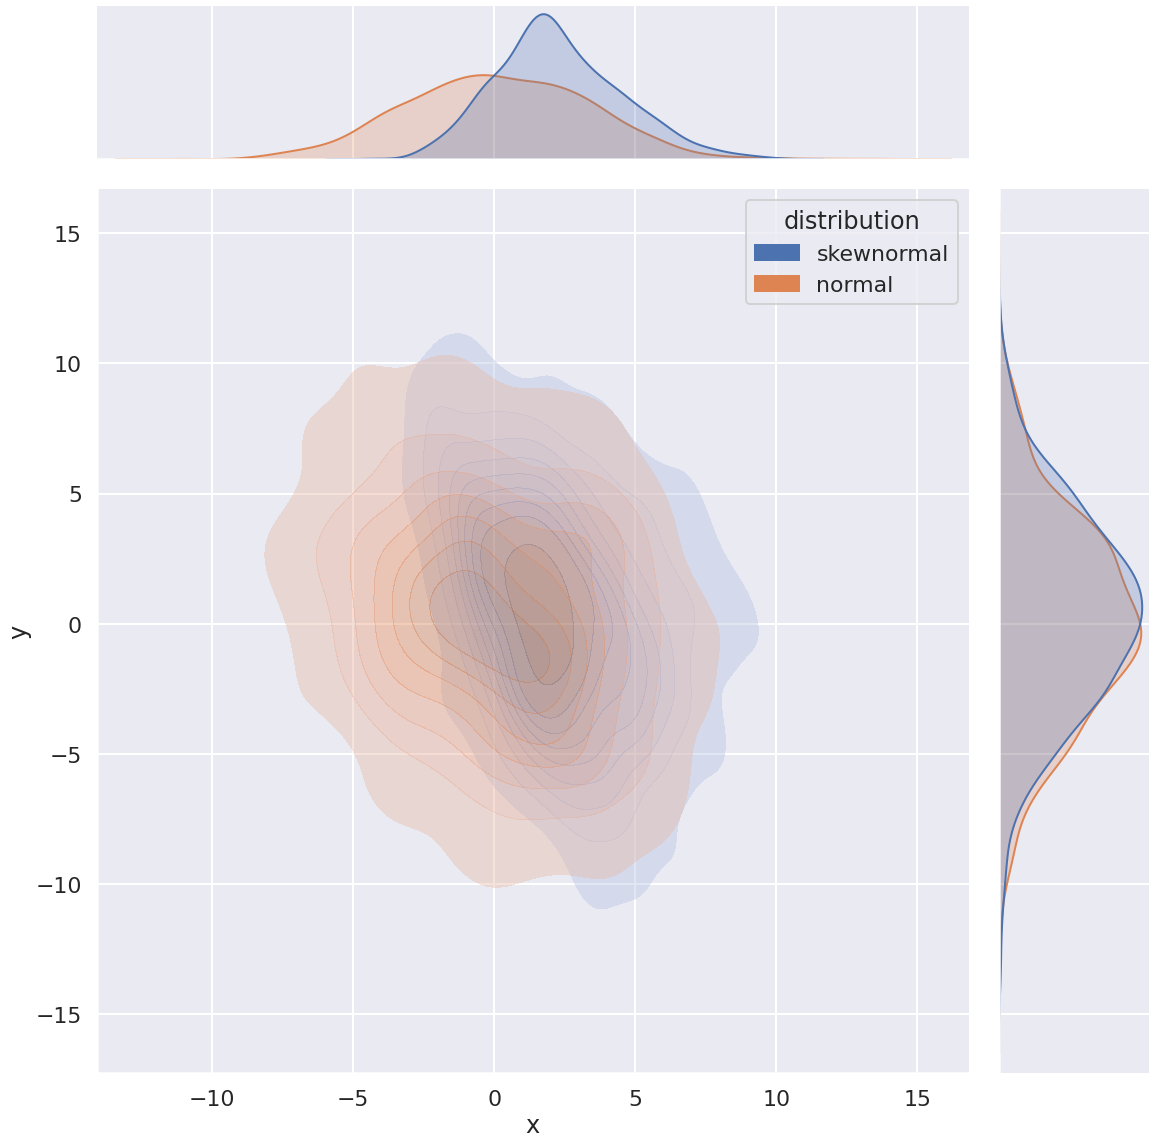

In [6]:
data_normal = random.multivariate_normal(key, tmean, tcov, shape=(n,))

data_skew = pd.DataFrame(data=data, columns=['x', 'y'])
data_skew['distribution'] = 'skewnormal'
data_normal = pd.DataFrame(data=data_normal, columns=['x', 'y'])
data_normal['distribution'] = 'normal'

plot_data = pd.concat([data_skew, data_normal])
sns.jointplot(data=plot_data, x='x', y='y', hue='distribution', kind='kde', fill=True, alpha=0.4, height=16)
plt.plot();

In [7]:
k = 0
maxit = 100

from optispd.manifold import SPD
from optispd.minimizer import minimizer

man = SPD(p=p)

optimizer = minimizer(
    man, method='rsd',
    maxiter=1, mingradnorm=tol,
    verbosity=0, logverbosity=False
    )

rng, *key = random.split(rng, 5)
sig_q = jnp.linalg.qr(random.normal(key[0], shape=(p,p)))[0]
sig_e = random.uniform(key[1], shape=(p,), minval=1, maxval=20)
sig = jnp.einsum('ij,j,kj->ik', sig_q, sig_e, sig_q)

limtheta = jnp.sqrt(jnp.min(sig_e))
th = random.uniform(key[2], shape=(p,))
th_norm = random.uniform(key[3], maxval=limtheta)
th = th / (jnp.linalg.norm(th) / th_norm)

logl = [nloglik(sig, th)]
print(logl)

[Buffer(9226.93475642, dtype=float64)]


In [8]:
while True:
    print("Iteration {} starts from:".format(k))
    print("\tSigma : {}".format(sig.ravel()))
    print("\t(Eigs: {})".format(jnp.linalg.eigvalsh(sig)))
    print("\tTheta: {} (norm: {})".format(th, jnp.linalg.norm(th)))
    print("\tLoglik : {:.2f}".format(logl[-1]))

    loglik_sig = jit(lambda x: nloglik(x, th))
    gradient_sig = jit(grad(loglik_sig))

    res = optimizer.solve(loglik_sig, gradient_sig, x=sig)

    sig = res.x

    print('\t...')

    loglik_th = jit(lambda x: nloglik(sig, x))
    gradient_psi = jit(grad(loglik_th))

    constrain = jnp.sqrt(jnp.min(jnp.linalg.eigvalsh(sig)))
    const_fun = jit(lambda x: jnp.linalg.norm(x) ** 2)
    jac = jit(grad(const_fun))
    # hess = jit(lambda x, v: jvp(grad(const_th), (x,), (v,)))
    
    if const_fun(th) > constrain:
        print('{} > {}, rescaling theta'.format(const_fun(th), constrain))
        rng, key = random.split(rng)
        th_norm = random.uniform(key, maxval=constrain)
        th = th / (jnp.linalg.norm(th) / th_norm)

    norm_constr = NonlinearConstraint(const_fun,
                                      0, constrain,
                                      jac=jac,
                                    #   hess=hess
                                      )
    # print('{} < {}'.format(const_th(theta), jnp.min(jnp.linalg.eigvalsh(sig))))
    res = minimize(loglik_th, th,
                   method="slsqp",
                   jac=gradient_psi,
                   constraints=norm_constr,
                   tol=tol,
                   options={'maxiter':10}
                   )
    th = res.x

    logl.append(nloglik(sig, th))
    k += 1

    print("And ends at:")
    print("\tSigma : {}".format(sig.ravel()))
    print("\t(Eigs: {})".format(jnp.linalg.eigvalsh(sig)))
    print("\tTheta: {} (norm: {})".format(th, jnp.linalg.norm(th)))
    print("\tLoglik : {:.2f}".format(logl[-1]))

    if jnp.isclose(logl[-2], logl[-1], rtol=tol) or k == maxit:
        break

    if jnp.isnan(logl[-1]).any():
        print("PANIC! NAN APPEARS")
        break
    
    print("\n---\n")


Iteration 0 starts from:
	Sigma : [5.9247432  0.28209777 0.28209777 3.62007297]
	(Eigs: [3.58604585 5.95877033])
	Theta: [1.08777348 1.19490876] (norm: 1.615876877357725)
	Loglik : 9226.93
	...
And ends at:
	Sigma : [ 823.6642731  1630.11388486 1630.11388486 3292.05306011]
	(Eigs: [  13.22983022 4102.48750299])
	Theta: [ 1.90622904 -0.05978457] (norm: 1.9071663167129305)
	Loglik : 8348.74

---

Iteration 1 starts from:
	Sigma : [ 823.6642731  1630.11388486 1630.11388486 3292.05306011]
	(Eigs: [  13.22983022 4102.48750299])
	Theta: [ 1.90622904 -0.05978457] (norm: 1.9071663167129305)
	Loglik : 8348.74
	...
And ends at:
	Sigma : [ 417.67589423  811.50614503  811.50614503 1657.60126461]
	(Eigs: [  16.41580526 2058.86135357])
	Theta: [ 1.8294238  -0.83955397] (norm: 2.012869169618027)
	Loglik : 7993.38

---

Iteration 2 starts from:
	Sigma : [ 417.67589423  811.50614503  811.50614503 1657.60126461]
	(Eigs: [  16.41580526 2058.86135357])
	Theta: [ 1.8294238  -0.83955397] (norm: 2.0128691696

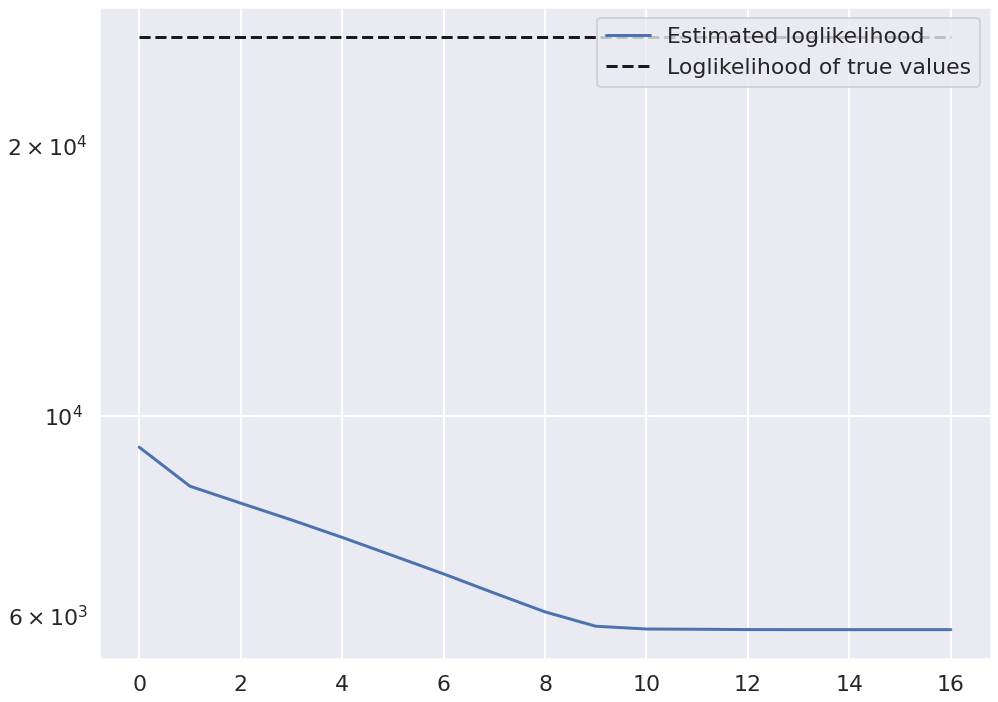

In [9]:
plt.plot(jnp.array(logl), label="Estimated loglikelihood")
plt.hlines(y=true_loglik, xmin=0, xmax=k, colors='k', linestyles='--', label="Loglikelihood of true values")
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [10]:
print("True values:")
print("\tSigma: {} (Eigs: {})".format(tcov.ravel(), tcov_e))
print("\tTheta: {} (norm: {})".format(ttheta, jnp.linalg.norm(ttheta)))
print("\tLoglik: {:.2f}".format(true_loglik))

print("Estimated values:")
print("\tSigma: {} (Eigs: {})".format(sig.ravel(), jnp.linalg.eigvalsh(sig)))
print("\tTheta: {} (norm: {})".format(th, jnp.linalg.norm(th)))
print("\tLoglik: {:.2f}".format(logl[-1]))


True values:
	Sigma: [10.27368226 -2.10466142 -2.10466142 14.52252436] (Eigs: [ 9.40765778 15.38854884])
	Theta: [2.85724638 0.57144928] (norm: 2.9138310082811376)
	Loglik: 26430.42
Estimated values:
	Sigma: [11.13552898 -2.00209328 -2.00209328 15.33709645] (Eigs: [10.33430138 16.13832405])
	Theta: [1.75236941 0.37934452] (norm: 1.7929586784067097)
	Loglik: 5779.57


In [25]:
nl = 200
x = jnp.linspace(jnp.min(data[:,0]), jnp.max(data[:,0]), nl)
y = jnp.linspace(jnp.min(data[:,1]), jnp.max(data[:,1]), nl)
from itertools import product
xy = jnp.array(list(product(x, y)))
#X, Y = jnp.meshgrid(x, y)

def prob_skew(dat, alpha, cv):
    Phi = norm.logcdf(jnp.dot(alpha, dat.T))
    phi = mvn.logpdf(dat, mean=tmean, cov=cv)
    return jnp.exp(2 + phi + Phi)


psi = sig - jnp.outer(th, th)
psitheta = jnp.linalg.solve(psi, th)
alpha = psitheta / jnp.sqrt(1. + jnp.dot(th.T, psitheta))
cv = psi - jnp.outer(alpha, alpha)

Z_est = prob_skew(xy, alpha, cv)
Z_est = jnp.where(Z_est < 1e-4, 0, Z_est)

tpsi = tcov - jnp.outer(ttheta, ttheta)
tpsitheta = jnp.linalg.solve(tpsi, ttheta)
talpha = tpsitheta / jnp.sqrt(1. + jnp.matmul(ttheta.T, tpsitheta))
tcv = tpsi - jnp.outer(talpha, talpha)

Z_true = prob_skew(xy, talpha, tcv)

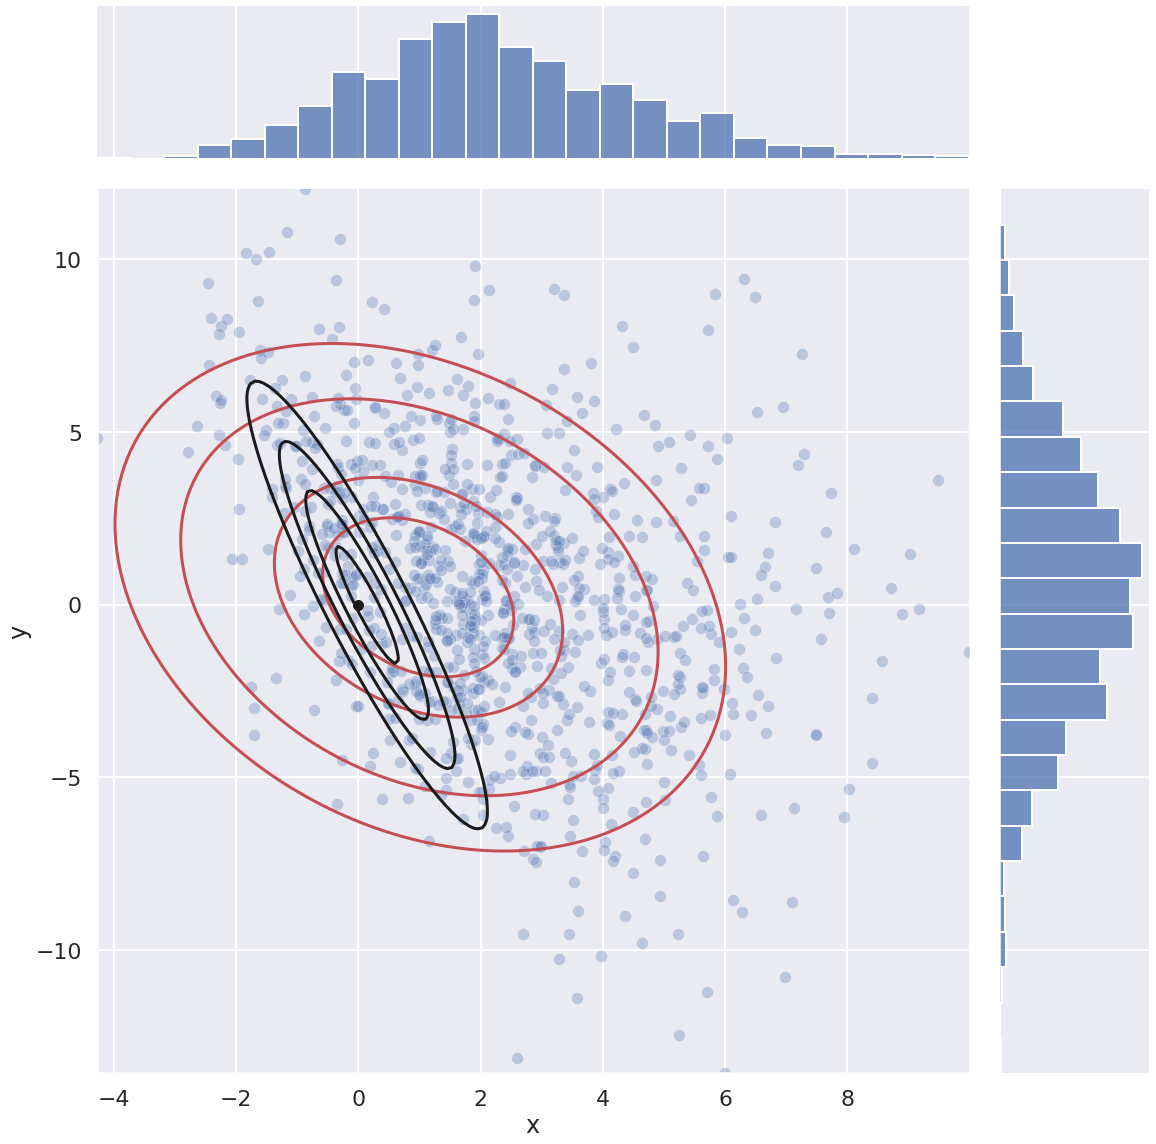

In [30]:
g = sns.jointplot(data=data_skew, x='x', y='y', kind='scatter', alpha=0.3, height=16)
g.ax_joint.plot([tmean[0]], [tmean[1]], 'ko', markersize=10)
g.ax_joint.contour(x, y, Z_est.reshape(nl, nl).T, colors='r', levels=[0.01, 0.02, 0.04, 0.05])
g.ax_joint.contour(x, y, Z_true.reshape(nl, nl).T, colors='k', levels=4)
plt.show()

In [24]:
pd.Series(jnp.where(Z_est < 1e-4, 0, Z_est)).describe()

count    40000.000000
mean         0.009782
std          0.014211
min          0.000000
25%          0.000355
50%          0.002620
75%          0.013459
max          0.059576
dtype: float64